# Stability and QC maps
This notebook explores the distribution of the data and how the data differs from frame to frame. 

This notebook loads the baseline files, creates histograms of the intensities, calculates and plots descriptive stats and the frame to frame differences

 
Author: Brynn Harris-Shanks

## Set-up

In [10]:
from pathlib import Path
import os
import sys
import yaml

# Locate repo root
repo_root = next(
    p for p in (Path.cwd(), *Path.cwd().parents)
    if (p / "config" / "config.yml").exists()
)

# Add code directory to import path
code_dir = repo_root / "code"
if str(code_dir) not in sys.path:
    sys.path.insert(0, str(code_dir))

# Load config
config_path = repo_root / "config" / "config.yml"
config = yaml.safe_load(config_path.read_text(encoding="utf-8"))

In [11]:
import matplotlib
import matplotlib.pyplot as plt
from IPython import get_ipython
import numpy as np
import pandas as pd
from utils import helper_functions as hf

In [12]:
# Inline backend
USE_WIDGET = False
ipy = get_ipython()
backend_mode = "inline"
if ipy is not None:
    try:
        ipy.run_line_magic("matplotlib", "inline")
    except Exception:
        pass
print(f"Matplotlib backend: {matplotlib.get_backend()} | mode={backend_mode}")

# Core paths
deriv_root = repo_root / config["paths"]["preprocessing"]
subjects = config["subjects"]["all"]
sample_subject = config["subjects"]["default"]
data_mode = "zscore"
sample_session_idx = 2
sample_frame_idx = 0

Matplotlib backend: inline | mode=inline


In [13]:
# Specific to this notebook
eda_cfg = config["eda"]
eda_root_name = eda_cfg["root_name"]
analysis_modes = eda_cfg["analysis_modes"]

fdiff_robust_pctl = tuple(float(x) for x in eda_cfg["frame_diff_robust_percentiles"])
spatial_eps = float(eda_cfg["spatial_eps"])
spatial_min_valid_samples = int(eda_cfg["spatial_min_valid_samples"])

CV_MODE_ORDER = list(analysis_modes)
PIX_MODE_ORDER = list(analysis_modes)
PIX_EPS = 1e-8
PIX_ROBUST_PCTL = (1.0, 99.0)
PIX_CV_CLIP = 5.0
PIX_ROOT_SUBDIR = "pixel_stability"

---
### Load Baseline Data

Load baseline sessions for model training.

In [14]:
for subject in subjects:
    data_output_dir = deriv_root / subject  # subject-specific output folder
    data_output_dir.mkdir(parents=True, exist_ok=True)
    if data_mode == "raw":
        baseline_output_dir = os.path.join(data_output_dir, "baseline_only")
    else:
        baseline_output_dir = os.path.join(
            data_output_dir, f"baseline_only_standardized/{data_mode}"
        )
    # Load all baseline sessions
    baseline_sessions = hf.load_saved_baseline_sessions(baseline_output_dir)

    # Print summary
    if len(baseline_sessions) > 0:
        print(f"\nBaseline Data Summary:{subject} ({data_mode})")
        print(f"  Total sessions: {len(baseline_sessions)}")
        total_frames = sum(s["frames"].shape[0] for s in baseline_sessions)
        print(f"  Total baseline frames: {total_frames:,}")

        spatial_shapes = [s["frames"].shape[1:] for s in baseline_sessions]
        unique_shapes = set(spatial_shapes)
        print(f"  Spatial dimensions: {unique_shapes}")

        # Show frame count distribution
        frame_counts = [s["frames"].shape[0] for s in baseline_sessions]
        print(
            f"  Frames per session: min={min(frame_counts)}, max={max(frame_counts)}, "
            f"mean={np.mean(frame_counts):.0f}, std={np.std(frame_counts):.0f}"
        )

        # first session
        if len(baseline_sessions) > 0:
            first_session = baseline_sessions[0]
            print(f"\n  First session ({first_session['session_id']}):")
            print(f"    Frames: {first_session['frames'].shape[0]}")
            print(f"    Shape: {first_session['frames'].shape}")
            print(f"    Dtype: {first_session['frames'].dtype}")
            print(
                f"Value range: [{first_session['frames'].min():.2f}, {first_session['frames'].max():.2f}]"
            )


Baseline Data Summary:secundo (zscore)
  Total sessions: 34
  Total baseline frames: 14,043
  Spatial dimensions: {(107, 128), (132, 128), (101, 128), (112, 128), (96, 128), (91, 128), (122, 128)}
  Frames per session: min=1, max=906, mean=413, std=202

  First session (Se01072020):
    Frames: 526
    Shape: (526, 101, 128)
    Dtype: float32
Value range: [-4.49, 10.65]


KeyboardInterrupt: 

---
## Exploratory data analysis

---

### 3. Pixel stability
will display just a sample acquisition, but will save plots for each acquisition
#### Mean map + std map
per acquisition

Loaded 34 baseline sessions
\n[secundo] pixel stability mean/std per acquisition | sessions=34


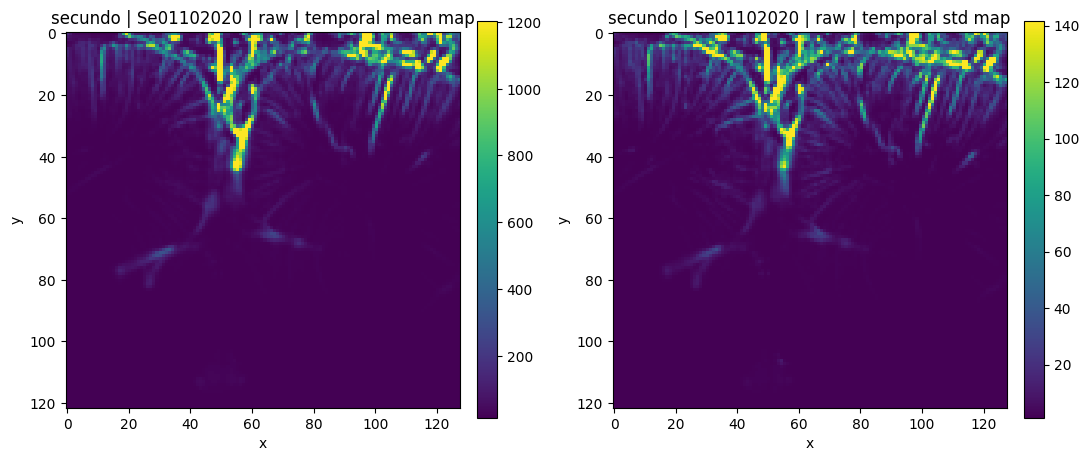

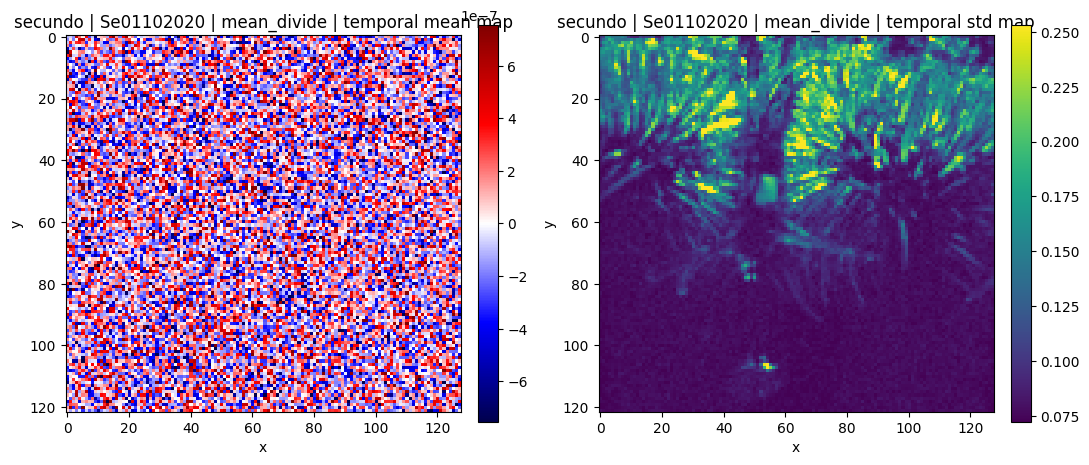

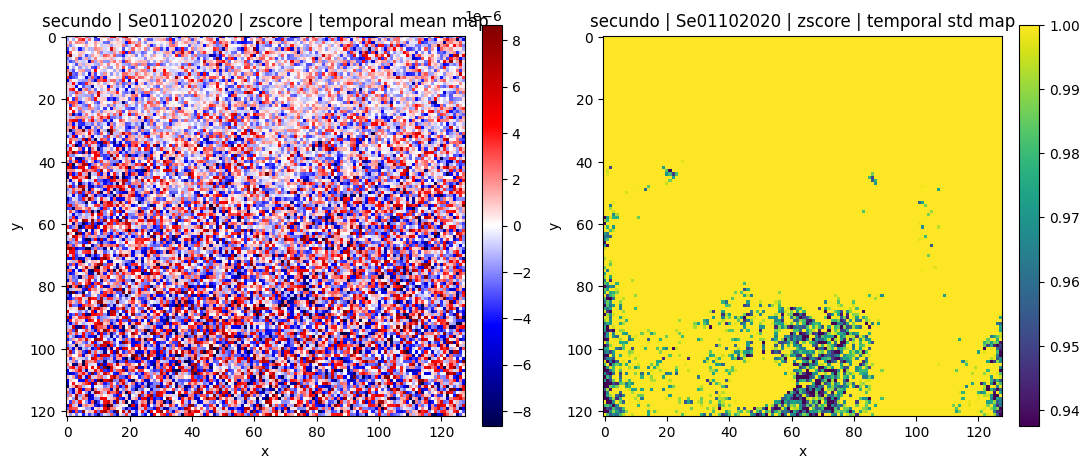

Saved per-acquisition mean/std maps to: c:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\secundo\eda\pixel_stability\mean_std_per_acquisition
Loaded 13 baseline sessions
\n[gus] pixel stability mean/std per acquisition | sessions=13
Saved per-acquisition mean/std maps to: c:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\gus\eda\pixel_stability\mean_std_per_acquisition


In [ ]:
def _pix_mode_transform(frames, mode, subject, session_id):
    arr = hf.load_saved_session_frames(deriv_root, subject, session_id, mode)

    if arr.shape != frames.shape:
        raise ValueError(
            f"Shape mismatch for {subject}/{session_id}/{mode}: "
            f"raw={frames.shape}, standardized={arr.shape}"
        )
    return arr


def _pix_subject_root(subject):
    return deriv_root / subject / eda_root_name / PIX_ROOT_SUBDIR


def _pix_finite(a):
    return a[np.isfinite(a)]


def _pix_stats(a):
    x = _pix_finite(a)
    if x.size == 0:
        return dict(min=np.nan, max=np.nan, mean=np.nan, median=np.nan)
    return dict(
        min=float(np.min(x)),
        max=float(np.max(x)),
        mean=float(np.mean(x)),
        median=float(np.median(x)),
    )


def _pix_limits(a, pctl=PIX_ROBUST_PCTL, nonnegative=False, symmetric=False):
    x = _pix_finite(a)
    if x.size == 0:
        return (0.0, 1.0)
    lo, hi = np.percentile(x, pctl)
    lo = float(lo)
    hi = float(hi)
    if symmetric:
        m = max(abs(lo), abs(hi), PIX_EPS)
        return (-m, m)
    if nonnegative:
        lo = max(0.0, lo)
    if hi <= lo + PIX_EPS:
        hi = lo + 1.0
    return (lo, hi)


for subject in subjects:
    baseline_dir = deriv_root / subject / "baseline_only"
    baseline_sessions = hf.load_all_baseline(str(baseline_dir))
    print(
        f"\\n[{subject}] pixel stability mean/std per acquisition | sessions={len(baseline_sessions)}"
    )
    if len(baseline_sessions) == 0:
        continue

    out_dir = _pix_subject_root(subject) / "mean_std_per_acquisition"
    out_dir.mkdir(parents=True, exist_ok=True)

    for s_idx, session in enumerate(baseline_sessions):
        session_id = session["session_id"]
        raw = session["frames"].astype(np.float32, copy=False)

        for mode in PIX_MODE_ORDER:
            arr = _pix_mode_transform(raw, mode, subject, session_id)
            mu_map = arr.mean(axis=0)
            sd_map = arr.std(axis=0)

            both_signs = (np.nanmin(mu_map) < 0.0) and (np.nanmax(mu_map) > 0.0)
            use_diverging = (mode == "mean_divide") or both_signs
            if use_diverging:
                mu_vmin, mu_vmax = _pix_limits(mu_map, symmetric=True)
                mu_cmap = "seismic"
            else:
                mu_vmin, mu_vmax = _pix_limits(mu_map)
                mu_cmap = "viridis"

            sd_vmin, sd_vmax = _pix_limits(sd_map, nonnegative=True)

            fig, axes = plt.subplots(1, 2, figsize=(11, 4.8))
            im0 = axes[0].imshow(mu_map, cmap=mu_cmap, vmin=mu_vmin, vmax=mu_vmax)
            axes[0].set_title(f"{subject} | {session_id} | {mode} | temporal mean map")
            axes[0].set_xlabel("x")
            axes[0].set_ylabel("y")
            fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

            im1 = axes[1].imshow(sd_map, cmap="viridis", vmin=sd_vmin, vmax=sd_vmax)
            axes[1].set_title(f"{subject} | {session_id} | {mode} | temporal std map")
            axes[1].set_xlabel("x")
            axes[1].set_ylabel("y")
            fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

            fig.tight_layout()
            out_fig = out_dir / f"{subject}_{session_id}_{mode}_mean_std_maps.png"
            fig.savefig(out_fig, dpi=180)

            rows = []
            for map_name, stats in [
                ("mean_map", _pix_stats(mu_map)),
                ("std_map", _pix_stats(sd_map)),
            ]:
                rows.append(
                    {
                        "subject": subject,
                        "session_id": session_id,
                        "mode": mode,
                        "map": map_name,
                        "min": stats["min"],
                        "max": stats["max"],
                        "mean": stats["mean"],
                        "median": stats["median"],
                    }
                )
            pd.DataFrame(rows).to_csv(
                out_dir / f"{subject}_{session_id}_{mode}_mean_std_maps_summary.csv",
                index=False,
            )

            if subject == sample_subject and s_idx == sample_session_idx:
                plt.show()
            else:
                plt.close(fig)

    print(f"Saved per-acquisition mean/std maps to: {out_dir}")

across acquisitions

Loaded 34 baseline sessions
\n[secundo] pixel stability mean/std across acquisitions | sessions=34
  - skip Se01092020: shape (112, 128) != (101, 128)
  - skip Se01102020: shape (122, 128) != (101, 128)
  - skip Se01122020: shape (122, 128) != (101, 128)
  - skip Se02122020: shape (122, 128) != (101, 128)
  - skip Se03022020: shape (112, 128) != (101, 128)
  - skip Se03092020: shape (112, 128) != (101, 128)
  - skip Se04022020: shape (112, 128) != (101, 128)
  - skip Se04032020: shape (91, 128) != (101, 128)
  - skip Se04082020: shape (112, 128) != (101, 128)
  - skip Se04092020: shape (112, 128) != (101, 128)
  - skip Se05022020: shape (112, 128) != (101, 128)
  - skip Se22092020: shape (122, 128) != (101, 128)
  - skip Se22102019: shape (132, 128) != (101, 128)
  - skip Se22112019: shape (112, 128) != (101, 128)
  - skip Se23072020: shape (96, 128) != (101, 128)
  - skip Se24022020: shape (112, 128) != (101, 128)
  - skip Se25062020: shape (107, 128) != (101, 128)
  - skip Se25082020

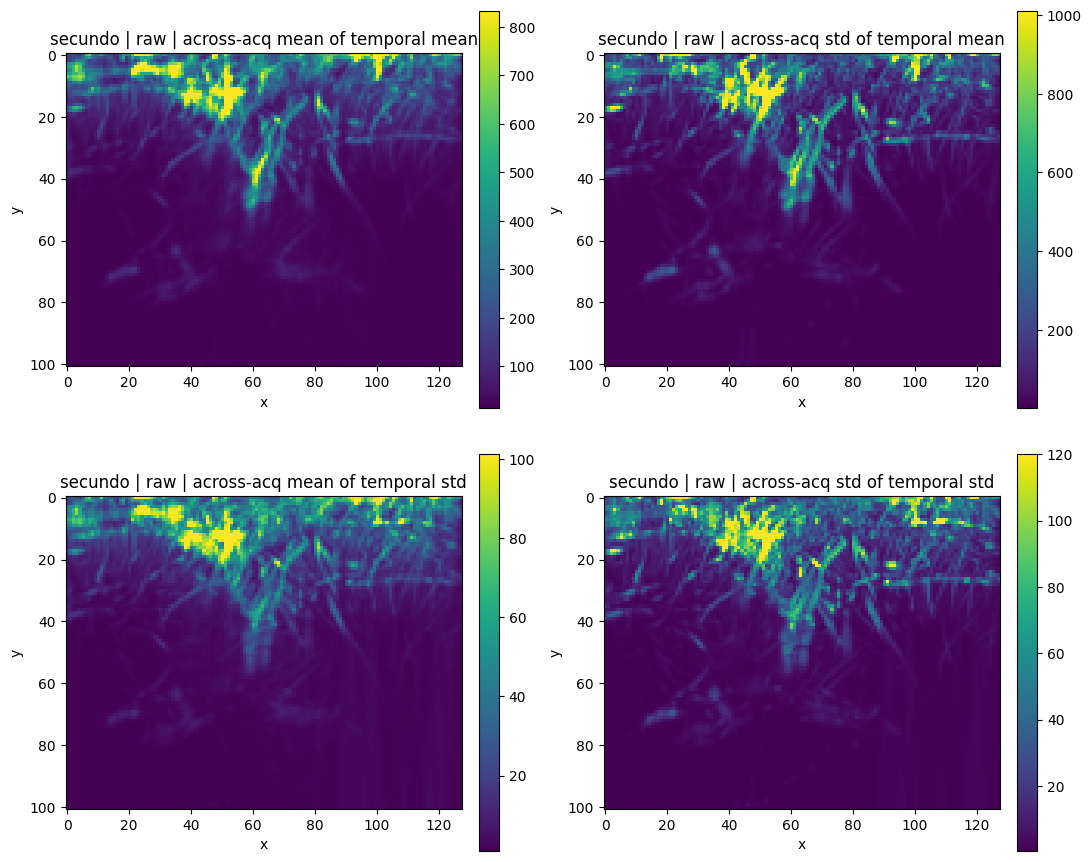

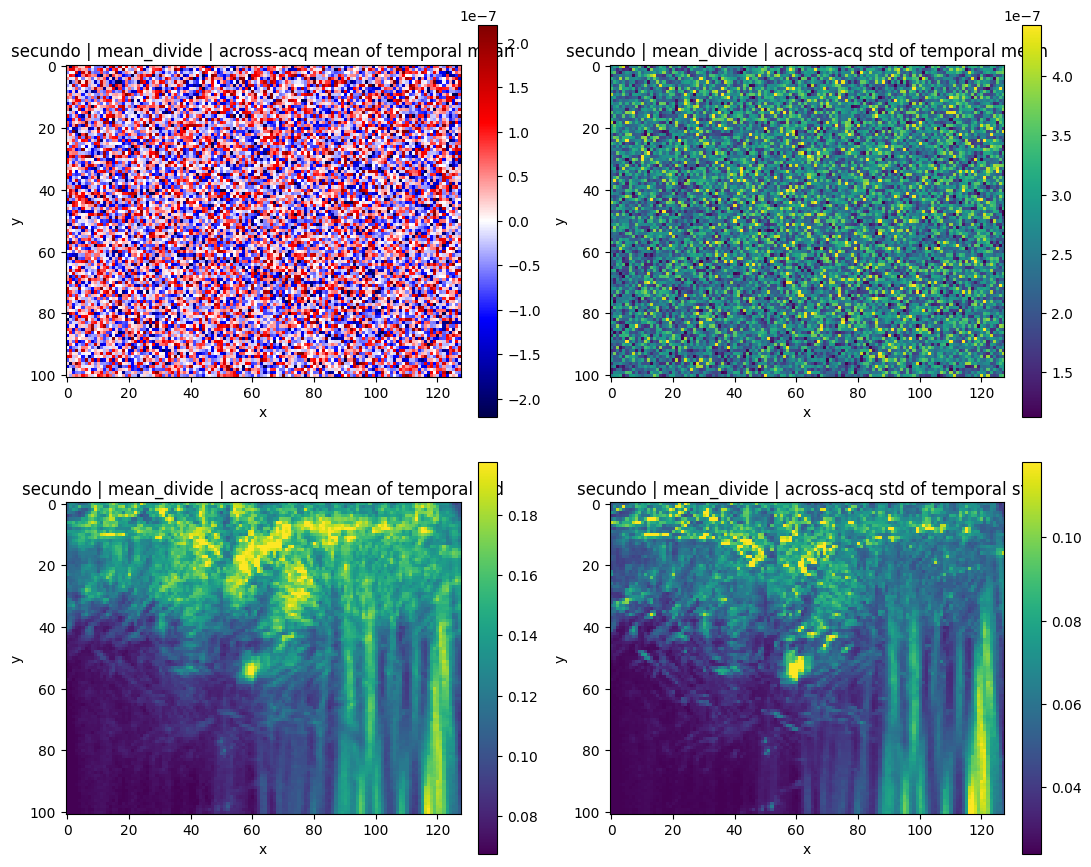

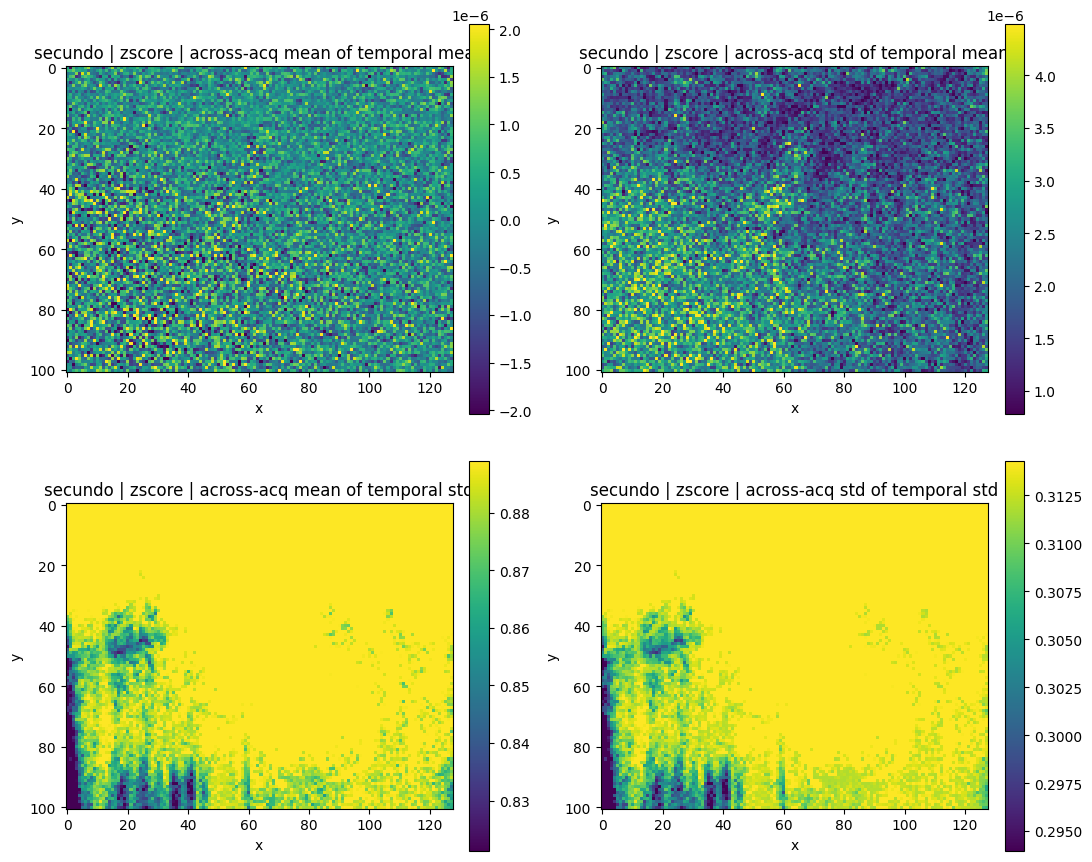

Saved across-acquisition mean/std maps to: c:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\secundo\eda\pixel_stability\mean_std_across_acquisitions
Loaded 13 baseline sessions
\n[gus] pixel stability mean/std across acquisitions | sessions=13
  - skip Gu06102020: shape (81, 128) != (112, 128)
  - skip Gu12042021: shape (101, 128) != (112, 128)
  - skip Gu17092020: shape (96, 128) != (112, 128)
  - skip Gu23072020: shape (122, 128) != (112, 128)
  - skip Gu29032021: shape (132, 128) != (112, 128)
  - skip Gu30032021: shape (101, 128) != (112, 128)
  - skip Gu30042021: shape (101, 128) != (112, 128)
Saved across-acquisition mean/std maps to: c:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\gus\eda\pixel_stability\mean_std_across_acquisitions


In [ ]:
for subject in subjects:
    baseline_dir = deriv_root / subject / "baseline_only"
    baseline_sessions = hf.load_all_baseline(str(baseline_dir))
    print(
        f"\\n[{subject}] pixel stability mean/std across acquisitions | sessions={len(baseline_sessions)}"
    )
    if len(baseline_sessions) == 0:
        continue

    out_dir = _pix_subject_root(subject) / "mean_std_across_acquisitions"
    out_dir.mkdir(parents=True, exist_ok=True)

    mode_collect = {mode: {"mu": [], "sd": []} for mode in PIX_MODE_ORDER}
    ref_shape = None

    for session in baseline_sessions:
        session_id = session["session_id"]
        raw = session["frames"].astype(np.float32, copy=False)
        shp = raw.shape[1:]
        if ref_shape is None:
            ref_shape = shp
        elif shp != ref_shape:
            print(f"  - skip {session_id}: shape {shp} != {ref_shape}")
            continue

        for mode in PIX_MODE_ORDER:
            arr = _pix_mode_transform(raw, mode, subject, session_id)
            mode_collect[mode]["mu"].append(arr.mean(axis=0))
            mode_collect[mode]["sd"].append(arr.std(axis=0))

    for mode in PIX_MODE_ORDER:
        if len(mode_collect[mode]["mu"]) == 0:
            print(f"  - skip mode={mode}: no valid sessions")
            continue

        MU = np.stack(mode_collect[mode]["mu"], axis=0)
        SD = np.stack(mode_collect[mode]["sd"], axis=0)

        mu_across_mean = MU.mean(axis=0)
        mu_across_std = MU.std(axis=0)
        sd_across_mean = SD.mean(axis=0)
        sd_across_std = SD.std(axis=0)

        fig, axes = plt.subplots(2, 2, figsize=(11, 9))
        panels = [
            (
                mu_across_mean,
                "seismic" if mode == "mean_divide" else "viridis",
                f"{subject} | {mode} | across-acq mean of temporal mean",
                False,
            ),
            (
                mu_across_std,
                "viridis",
                f"{subject} | {mode} | across-acq std of temporal mean",
                True,
            ),
            (
                sd_across_mean,
                "viridis",
                f"{subject} | {mode} | across-acq mean of temporal std",
                True,
            ),
            (
                sd_across_std,
                "viridis",
                f"{subject} | {mode} | across-acq std of temporal std",
                True,
            ),
        ]

        for ax, (data, cmap, title, nonneg) in zip(axes.ravel(), panels):
            if cmap == "seismic":
                vmin, vmax = _pix_limits(data, symmetric=True)
            else:
                vmin, vmax = _pix_limits(data, nonnegative=nonneg)
            im = ax.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)
            ax.set_title(title)
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        fig.tight_layout()
        out_fig = out_dir / f"{subject}_{mode}_mean_std_across_acquisitions_maps.png"
        fig.savefig(out_fig, dpi=180)

        rows = []
        for map_name, data in [
            ("mu_across_mean", mu_across_mean),
            ("mu_across_std", mu_across_std),
            ("sd_across_mean", sd_across_mean),
            ("sd_across_std", sd_across_std),
        ]:
            st = _pix_stats(data)
            rows.append(
                {
                    "subject": subject,
                    "mode": mode,
                    "map": map_name,
                    "n_sessions": int(MU.shape[0]),
                    "min": st["min"],
                    "max": st["max"],
                    "mean": st["mean"],
                    "median": st["median"],
                }
            )
        pd.DataFrame(rows).to_csv(
            out_dir / f"{subject}_{mode}_mean_std_across_acquisitions_summary.csv",
            index=False,
        )

        if subject == sample_subject:
            plt.show()
        else:
            plt.close(fig)

    print(f"Saved across-acquisition mean/std maps to: {out_dir}")

####  CV map
per acquisition

Loaded 34 baseline sessions
\n[secundo] pixel stability CV per acquisition | sessions=34


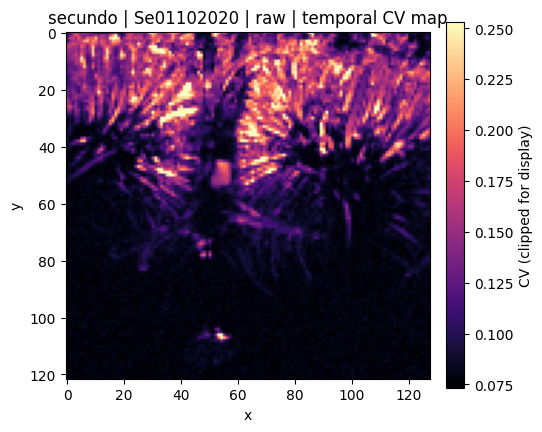

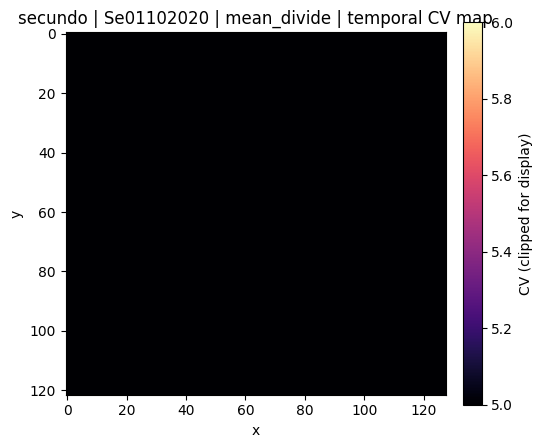

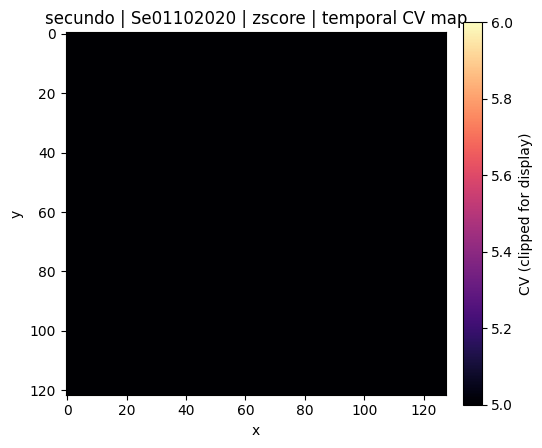

Saved per-acquisition CV maps to: c:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\secundo\eda\pixel_stability\cv_per_acquisition
Loaded 13 baseline sessions
\n[gus] pixel stability CV per acquisition | sessions=13
Saved per-acquisition CV maps to: c:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\gus\eda\pixel_stability\cv_per_acquisition


In [ ]:
for subject in subjects:
    baseline_dir = deriv_root / subject / "baseline_only"
    baseline_sessions = hf.load_all_baseline(str(baseline_dir))
    print(
        f"\\n[{subject}] pixel stability CV per acquisition | sessions={len(baseline_sessions)}"
    )
    if len(baseline_sessions) == 0:
        continue

    out_dir = _pix_subject_root(subject) / "cv_per_acquisition"
    out_dir.mkdir(parents=True, exist_ok=True)

    for s_idx, session in enumerate(baseline_sessions):
        session_id = session["session_id"]
        raw = session["frames"].astype(np.float32, copy=False)

        for mode in CV_MODE_ORDER:
            arr = _pix_mode_transform(raw, mode, subject, session_id)
            mu_map = arr.mean(axis=0)
            sd_map = arr.std(axis=0)
            cv_map = sd_map / (np.abs(mu_map) + PIX_EPS)
            cv_map = np.where(np.isfinite(cv_map), cv_map, np.nan)

            cv_disp = np.clip(cv_map, 0.0, PIX_CV_CLIP)
            cv_vmin, cv_vmax = _pix_limits(cv_disp, nonnegative=True)

            fig, ax = plt.subplots(1, 1, figsize=(5.5, 4.8))
            im = ax.imshow(cv_disp, cmap="magma", vmin=cv_vmin, vmax=cv_vmax)
            ax.set_title(f"{subject} | {session_id} | {mode} | temporal CV map")
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            fig.colorbar(
                im, ax=ax, fraction=0.046, pad=0.04, label="CV (clipped for display)"
            )
            fig.tight_layout()

            out_fig = out_dir / f"{subject}_{session_id}_{mode}_cv_map.png"
            fig.savefig(out_fig, dpi=180)

            st = _pix_stats(cv_map)
            pd.DataFrame(
                [
                    {
                        "subject": subject,
                        "session_id": session_id,
                        "mode": mode,
                        "map": "cv_map",
                        "eps": PIX_EPS,
                        "clip_for_display": PIX_CV_CLIP,
                        "min": st["min"],
                        "max": st["max"],
                        "mean": st["mean"],
                        "median": st["median"],
                    }
                ]
            ).to_csv(
                out_dir / f"{subject}_{session_id}_{mode}_cv_map_summary.csv",
                index=False,
            )

            if subject == sample_subject and s_idx == sample_session_idx:
                plt.show()
            else:
                plt.close(fig)

    print(f"Saved per-acquisition CV maps to: {out_dir}")

across acquisitions

Loaded 34 baseline sessions
\n[secundo] pixel stability CV across acquisitions | sessions=34
  - skip Se01092020: shape (112, 128) != (101, 128)
  - skip Se01102020: shape (122, 128) != (101, 128)
  - skip Se01122020: shape (122, 128) != (101, 128)
  - skip Se02122020: shape (122, 128) != (101, 128)
  - skip Se03022020: shape (112, 128) != (101, 128)
  - skip Se03092020: shape (112, 128) != (101, 128)
  - skip Se04022020: shape (112, 128) != (101, 128)
  - skip Se04032020: shape (91, 128) != (101, 128)
  - skip Se04082020: shape (112, 128) != (101, 128)
  - skip Se04092020: shape (112, 128) != (101, 128)
  - skip Se05022020: shape (112, 128) != (101, 128)
  - skip Se22092020: shape (122, 128) != (101, 128)
  - skip Se22102019: shape (132, 128) != (101, 128)
  - skip Se22112019: shape (112, 128) != (101, 128)
  - skip Se23072020: shape (96, 128) != (101, 128)
  - skip Se24022020: shape (112, 128) != (101, 128)
  - skip Se25062020: shape (107, 128) != (101, 128)
  - skip Se25082020: shap

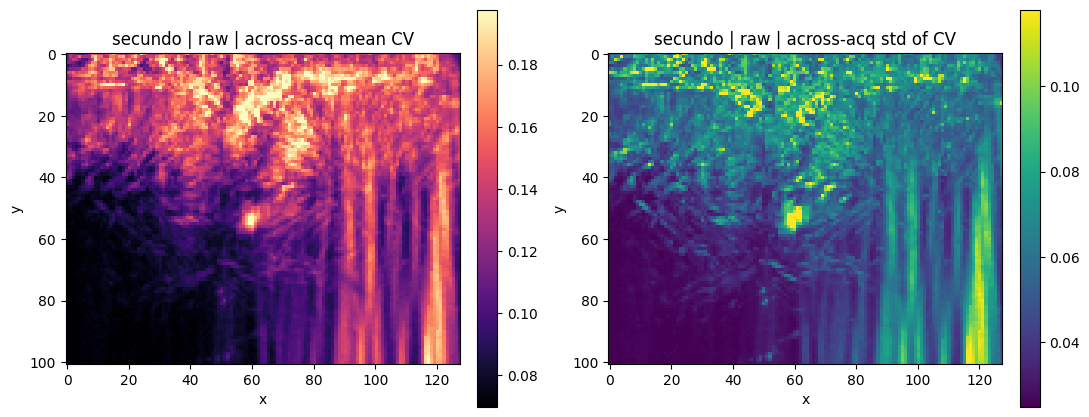

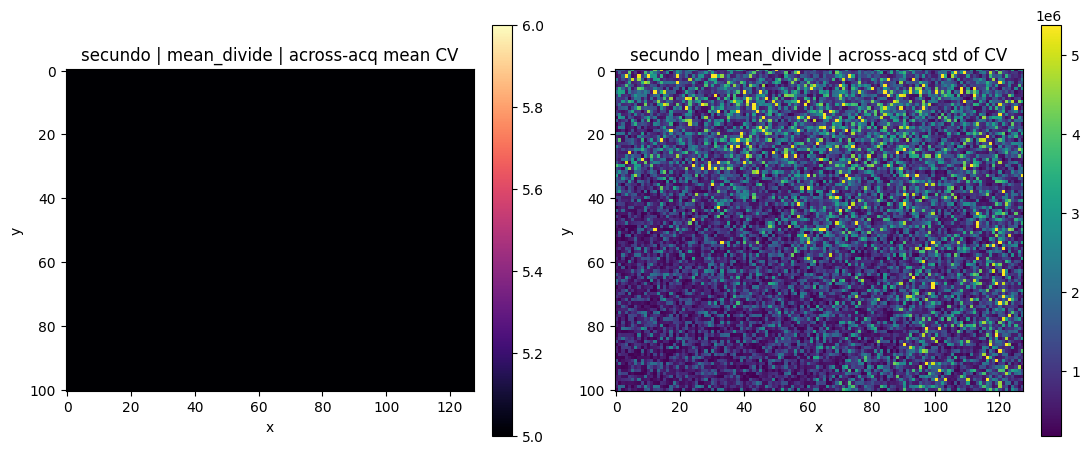

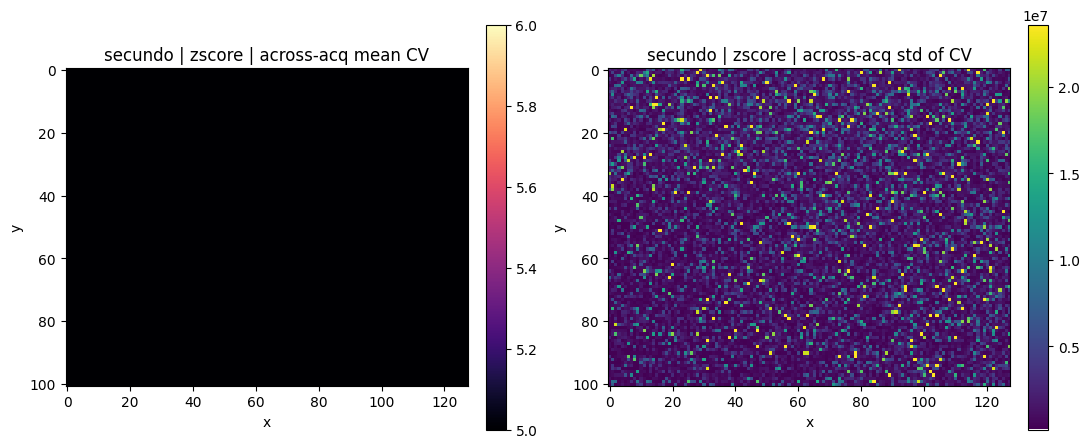

Saved across-acquisition CV maps to: c:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\secundo\eda\pixel_stability\cv_across_acquisitions
Loaded 13 baseline sessions
\n[gus] pixel stability CV across acquisitions | sessions=13
  - skip Gu06102020: shape (81, 128) != (112, 128)
  - skip Gu12042021: shape (101, 128) != (112, 128)
  - skip Gu17092020: shape (96, 128) != (112, 128)
  - skip Gu23072020: shape (122, 128) != (112, 128)
  - skip Gu29032021: shape (132, 128) != (112, 128)
  - skip Gu30032021: shape (101, 128) != (112, 128)
  - skip Gu30042021: shape (101, 128) != (112, 128)
Saved across-acquisition CV maps to: c:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\gus\eda\pixel_stability\cv_across_acquisitions


In [ ]:
for subject in subjects:
    baseline_dir = deriv_root / subject / "baseline_only"
    baseline_sessions = hf.load_all_baseline(str(baseline_dir))
    print(
        f"\\n[{subject}] pixel stability CV across acquisitions | sessions={len(baseline_sessions)}"
    )
    if len(baseline_sessions) == 0:
        continue

    out_dir = _pix_subject_root(subject) / "cv_across_acquisitions"
    out_dir.mkdir(parents=True, exist_ok=True)

    mode_collect = {mode: [] for mode in CV_MODE_ORDER}
    ref_shape = None

    for session in baseline_sessions:
        session_id = session["session_id"]
        raw = session["frames"].astype(np.float32, copy=False)
        shp = raw.shape[1:]
        if ref_shape is None:
            ref_shape = shp
        elif shp != ref_shape:
            print(f"  - skip {session_id}: shape {shp} != {ref_shape}")
            continue

        for mode in CV_MODE_ORDER:
            arr = _pix_mode_transform(raw, mode, subject, session_id)
            mu_map = arr.mean(axis=0)
            sd_map = arr.std(axis=0)
            cv_map = sd_map / (np.abs(mu_map) + PIX_EPS)
            cv_map = np.where(np.isfinite(cv_map), cv_map, np.nan)
            mode_collect[mode].append(cv_map)

    for mode in CV_MODE_ORDER:
        if len(mode_collect[mode]) == 0:
            print(f"  - skip mode={mode}: no valid sessions")
            continue

        CV = np.stack(mode_collect[mode], axis=0)
        cv_across_mean = np.nanmean(CV, axis=0)
        cv_across_std = np.nanstd(CV, axis=0)

        mean_disp = np.clip(cv_across_mean, 0.0, PIX_CV_CLIP)
        mean_vmin, mean_vmax = _pix_limits(mean_disp, nonnegative=True)
        std_vmin, std_vmax = _pix_limits(cv_across_std, nonnegative=True)

        fig, axes = plt.subplots(1, 2, figsize=(11, 4.8))
        im0 = axes[0].imshow(mean_disp, cmap="magma", vmin=mean_vmin, vmax=mean_vmax)
        axes[0].set_title(f"{subject} | {mode} | across-acq mean CV")
        axes[0].set_xlabel("x")
        axes[0].set_ylabel("y")
        fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

        im1 = axes[1].imshow(
            cv_across_std, cmap="viridis", vmin=std_vmin, vmax=std_vmax
        )
        axes[1].set_title(f"{subject} | {mode} | across-acq std of CV")
        axes[1].set_xlabel("x")
        axes[1].set_ylabel("y")
        fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

        fig.tight_layout()
        out_fig = out_dir / f"{subject}_{mode}_cv_across_acquisitions_maps.png"
        fig.savefig(out_fig, dpi=180)

        rows = []
        for map_name, data in [
            ("cv_across_mean", cv_across_mean),
            ("cv_across_std", cv_across_std),
        ]:
            st = _pix_stats(data)
            rows.append(
                {
                    "subject": subject,
                    "mode": mode,
                    "map": map_name,
                    "n_sessions": int(CV.shape[0]),
                    "eps": PIX_EPS,
                    "clip_for_display": PIX_CV_CLIP,
                    "min": st["min"],
                    "max": st["max"],
                    "mean": st["mean"],
                    "median": st["median"],
                }
            )
        pd.DataFrame(rows).to_csv(
            out_dir / f"{subject}_{mode}_cv_across_acquisitions_summary.csv",
            index=False,
        )

        if subject == sample_subject:
            plt.show()
        else:
            plt.close(fig)

    print(f"Saved across-acquisition CV maps to: {out_dir}")